<a href="https://colab.research.google.com/github/GeorgeShmelin/Masterschool_time_series_Project_supermarket_favorita/blob/main/2_ARIMA_TimeSeries_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Google Colab notebook operates on a real-time download of selected data from Kaggle’s “Favorita” dataset, retrieved via a concise and transparent SQL query. All initial filtering — including the specification of the time period — is handled directly within the SQL. Users interested in alternative configurations, such as different time frames, data volumes, or geographic regions, can easily adapt the query to meet their specific requirements. The selected time frame begins on 15 September 2016, chosen deliberately due to a brief but significant drop in oil prices around Christmas 2016. This fluctuation provided a rare opportunity to observe consumer purchasing behavior in Ecuador under stress, revealing deeper insights than would be possible from analyzing a more stable economic period.

# Libraries

## original data download

In [ ]:
# !pip install kagglehub
import kagglehub

In [ ]:
import joblib # Save the DataFrame to a compressed file

In [ ]:
import sqlite3
import os
import gc

In [ ]:
import sqlalchemy as sa
from google.colab import files
from sqlalchemy import text
from sqlalchemy import create_engine

In [ ]:
from sklearn.neighbors import NearestNeighbors  # Import NearestNeighbors for cleaning
from sklearn.neighbors import KNeighborsRegressor

## essentials

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

## libraries for models

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
from xgboost import XGBRegressor

In [ ]:
from scipy.signal import correlate
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import Holt

-------------------------------------------------------------------------------

# Data download and initial transformations

In [ ]:
'''
# the resulting data set was too small for reasonable filtered analysis

from google.colab import drive
drive.mount('/content/drive')

# my data set was already filtered by KNN in the previous step

file_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/df_train.csv'
df = pd.read_csv(file_path, index_col=0)

# Check if 'date' column exists
if 'date' not in df.columns:
    # If 'date' is not found, try another likely column name or
    # investigate the CSV file structure
    if 'train_date' in df.columns:
        df.rename(columns={'train_date': 'date'}, inplace=True)
        print("Renamed 'train_date' column to 'date'")
    else:
        raise KeyError(f"Column 'date' or a suitable alternative not found in DataFrame. Available columns are: {df.columns.tolist()}")

# Now you can proceed with your filtering:
df = df[df['date'] > '2016-09-15']
'''

'\n# the resulting data set was too small for reasonable filtered analysis\n\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# my data set was already filtered by KNN in the previous step\n\nfile_path = \'/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/df_train.csv\'\ndf = pd.read_csv(file_path, index_col=0)\n\n# Check if \'date\' column exists\nif \'date\' not in df.columns:\n    # If \'date\' is not found, try another likely column name or\n    # investigate the CSV file structure\n    if \'train_date\' in df.columns:\n        df.rename(columns={\'train_date\': \'date\'}, inplace=True)\n        print("Renamed \'train_date\' column to \'date\'")\n    else:\n        raise KeyError(f"Column \'date\' or a suitable alternative not found in DataFrame. Available columns are: {df.columns.tolist()}")\n\n# Now you can proceed with your filtering:\ndf = df[df[\'date\'] > \'2016-09-15\']\n'

In [ ]:
# Download latest version
path = kagglehub.dataset_download("siliconx/favoritagrocerysalesforecastingextracted")

print("Path to dataset files:", path)

100%|██████████| 850M/850M [00:21<00:00, 41.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/siliconx/favoritagrocerysalesforecastingextracted/versions/1


In [ ]:
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['test.csv', 'stores.csv', 'train.csv', 'items.csv', 'transactions.csv', 'holidays_events.csv', 'oil.csv', 'sample_submission.csv']


In [ ]:
# Connect to SQLite
conn = sqlite3.connect("favorita.db")

# Change this line per file
filename = 'oil.csv'
file_path = os.path.join(path, filename)

# Load CSV
df = pd.read_csv(file_path)
table_name = filename.replace('.csv', '')

# Load to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"✅ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"🔢 Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for key info
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"🔑 Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"ℹ️ No obvious join keys found in '{table_name}'")

✅ Loaded 'oil.csv' into table 'oil'
🔢 Table 'oil' has 1,218 rows.
🔑 Candidate keys or join fields in 'oil': ['date']


In [ ]:
# Change this line per file
filename = 'items.csv'
file_path = os.path.join(path, filename)

# Load CSV
df = pd.read_csv(file_path)
table_name = filename.replace('.csv', '')

# Load to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"✅ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"🔢 Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for key info
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"🔑 Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"ℹ️ No obvious join keys found in '{table_name}'")

✅ Loaded 'items.csv' into table 'items'
🔢 Table 'items' has 4,100 rows.
🔑 Candidate keys or join fields in 'items': ['item_nbr']


In [ ]:
# Change this line per file
filename = 'holidays_events.csv'
file_path = os.path.join(path, filename)

# Load CSV
df = pd.read_csv(file_path)
table_name = filename.replace('.csv', '')

# Load to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"✅ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"🔢 Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for key info
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"🔑 Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"ℹ️ No obvious join keys found in '{table_name}'")

✅ Loaded 'holidays_events.csv' into table 'holidays_events'
🔢 Table 'holidays_events' has 350 rows.
🔑 Candidate keys or join fields in 'holidays_events': ['date']


In [ ]:
# Set up file
filename = 'stores.csv'
file_path = os.path.join(path, filename)

# Load and filter for Guayas
df = pd.read_csv(file_path)
df = df[df['state'] == 'Guayas']  # 👈 Filter

table_name = filename.replace('.csv', '')

# Save to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"✅ Loaded '{filename}' into table '{table_name}' (only state = 'Guayas')")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"🔢 Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for join keys
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"🔑 Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"ℹ️ No obvious join keys found in '{table_name}'")

✅ Loaded 'stores.csv' into table 'stores' (only state = 'Guayas')
🔢 Table 'stores' has 11 rows.
🔑 Candidate keys or join fields in 'stores': ['store_nbr']


In [ ]:
# Change this line per file
filename = 'transactions.csv'
file_path = os.path.join(path, filename)

# Load CSV
df = pd.read_csv(file_path)
table_name = filename.replace('.csv', '')

# Load to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"✅ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"🔢 Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for key info
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"🔑 Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"ℹ️ No obvious join keys found in '{table_name}'")

✅ Loaded 'transactions.csv' into table 'transactions'
🔢 Table 'transactions' has 83,488 rows.
🔑 Candidate keys or join fields in 'transactions': ['store_nbr', 'date']


In [ ]:
del files
del possible_keys
del columns
del date_like
del primary_like
del df
del row_count_df
del query

train.csv is a big in this dataset - like 125 million rows

In [ ]:
# Paths and file setup
filename = 'train.csv'
file_path = os.path.join(path, filename)
table_name = filename.replace('.csv', '')

# Date filter range
DATE_START = '2016-09-15'
DATE_END = '2018-12-31'

# Sampling + row cap
SAMPLE_RATIO = 0.01
MAX_ROWS = 100_000
total_saved_rows = 0

# Columns to keep from CSV
columns_to_keep = ['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion']

In [ ]:
# Connect to SQLite
conn = sqlite3.connect("favorita.db")
cursor = conn.cursor()

# Check if the table exists
cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'")
table_exists = cursor.fetchone()

# If not exists, create it with correct schema
if not table_exists:
    create_sql = f"""
        CREATE TABLE {table_name} (
            date DATETIME,
            store_nbr INTEGER,
            item_nbr INTEGER,
            unit_sales REAL,
            onpromotion INTEGER
        )
    """
    conn.execute(create_sql)
    print(f"✅ Created table '{table_name}' with all expected columns")
else:
    # Validate column schema
    cursor.execute(f"PRAGMA table_info({table_name})")
    existing_columns = [col[1] for col in cursor.fetchall()]
    if 'onpromotion' not in existing_columns:
        try:
            conn.execute(f"ALTER TABLE {table_name} ADD COLUMN onpromotion INTEGER")
            print(f"➕ Added missing column 'onpromotion' to '{table_name}'")
        except sqlite3.OperationalError as e:
            print(f"⚠️ Could not alter table to add 'onpromotion': {e}")
    else:
        print(f"ℹ️ Table '{table_name}' exists and includes 'onpromotion'")

✅ Created table 'train' with all expected columns


In [ ]:
# Read CSV in chunks
chunks = pd.read_csv(file_path, chunksize=1_00_000, parse_dates=['date'])

for chunk in chunks:
    # Filter date
    chunk = chunk[(chunk['date'] >= DATE_START) & (chunk['date'] < DATE_END)]
    if chunk.empty:
        continue

    # Round to hour
    chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce').dt.floor('H')

    # Ensure onpromotion column
    if 'onpromotion' not in chunk.columns:
        chunk['onpromotion'] = 0
    chunk['onpromotion'] = chunk['onpromotion'].fillna(False).astype('int8')  # Make it small

    # Downcast numerics
    chunk['store_nbr'] = pd.to_numeric(chunk['store_nbr'], downcast='integer')
    chunk['item_nbr'] = pd.to_numeric(chunk['item_nbr'], downcast='integer')
    chunk['unit_sales'] = pd.to_numeric(chunk['unit_sales'], downcast='float')

    # Try float16 if it fits (warning: less precise)
    if chunk['unit_sales'].max() < 65504:  # float16 upper limit
        chunk['unit_sales'] = chunk['unit_sales'].astype('float16')

    # Sample
    chunk = chunk.sample(frac=SAMPLE_RATIO, random_state=42)

    # Cap rows
    if total_saved_rows + len(chunk) > MAX_ROWS:
        chunk = chunk.iloc[:MAX_ROWS - total_saved_rows]

    # Keep only expected columns
    chunk = chunk[columns_to_keep]

    # Save
    chunk.to_sql(table_name, conn, if_exists='append', index=False)
    total_saved_rows += len(chunk)

    if total_saved_rows >= MAX_ROWS:
        break

print(f"✅ Loaded {total_saved_rows} rows into '{table_name}'")

✅ Loaded 100000 rows into 'train'


I take here the shopping data only after 15.09.2016, as about 15.03.2017 oil price droped quite significantly (Equador is an oil exporting country) and the shopping activity also dropped sharply. After that date the shopping activity started stadily to recover.

In [ ]:
chunk['onpromotion'] = chunk['onpromotion'].fillna(False).astype('int8')
chunk['unit_sales'] = pd.to_numeric(chunk['unit_sales'], downcast='float')
if chunk['unit_sales'].max() < 65504:
    chunk['unit_sales'] = chunk['unit_sales'].astype('float16')

In [ ]:
# Row count
row_count = pd.read_sql(f"SELECT COUNT(*) AS row_count FROM {table_name}", conn).iloc[0, 0]
print(f"🔢 Table '{table_name}' has {row_count:,} rows.")

# Keys for join
sample = pd.read_sql(f"SELECT * FROM {table_name} LIMIT 5", conn)
columns = sample.columns.tolist()
keys = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower() or 'date' in col.lower()]
print(f"🔑 Candidate keys or join fields in '{table_name}': {keys}")

🔢 Table 'train' has 100,000 rows.
🔑 Candidate keys or join fields in 'train': ['date', 'store_nbr', 'item_nbr']


In [ ]:
del cursor
del row_count
del sample
del keys
del columns

From SQL to DataFrame

In [ ]:
database_connection_string = "sqlite:///favorita.db"  # Assuming the database file is named 'favorita.db'

# Create the engine
engine = sa.create_engine(database_connection_string)

In [ ]:
query_train = """
WITH top_families AS (
    SELECT items.family
    FROM train
    JOIN items ON train.item_nbr = items.item_nbr
    WHERE train.unit_sales >= 0
    GROUP BY items.family
    ORDER BY SUM(train.unit_sales) DESC
    LIMIT 3
)

SELECT
    train.unit_sales,
    train.date AS train_date,
    train.store_nbr,
    train.item_nbr,
    train.onpromotion,

    oil.dcoilwtico,

    holidays_events.type AS holiday_type,
    holidays_events.locale,
    holidays_events.transferred,

    stores.city,
    stores.type AS store_type,
    stores.cluster AS store_cluster,

    items.family AS items_family,
    items.class AS item_class,
    items.perishable AS perishable_items,

    transactions.transactions

FROM train
LEFT JOIN oil
  ON DATE(train.date) = DATE(oil.date)
LEFT JOIN holidays_events
  ON DATE(train.date) = DATE(holidays_events.date)
LEFT JOIN stores
  ON train.store_nbr = stores.store_nbr
INNER JOIN items
  ON train.item_nbr = items.item_nbr
INNER JOIN transactions
  ON DATE(train.date) = DATE(transactions.date)
     AND train.store_nbr = transactions.store_nbr

WHERE train.unit_sales >= 0
  AND items.family IN (SELECT family FROM top_families)
  AND train.date > '2014-04-01'

LIMIT 100000;
"""

In [ ]:
df_train_download = pd.read_sql_query(query_train, engine)

In [ ]:
df = df_train_download.copy()
df.shape

(59233, 16)

## Data cleaning and encoding

In [ ]:
df['onpromotion'] = df['onpromotion'].fillna(0).astype(bool)
df['onpromotion'] = df['onpromotion'].astype(int)

In [ ]:
# Ensure 'date' is a datetime object
df['date'] = pd.to_datetime(df['train_date']) # Renamed 'train_date' column to 'date'

# Extract and add new columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week # Extract week number from 'date' column

In [ ]:
# Check if 'index' column exists before deleting
if 'index' in df.columns:
    del df['index']

In [ ]:
# Check if 'item_class' column exists before accessing it
if 'item_class' in df.columns:
    print(df['item_class'].nunique())
else:
    print("The 'item_class' column does not exist in the DataFrame.")

103


In [ ]:
df['item_nbr'].nunique()

2056

In [ ]:
# df['store_nbr'].value_counts()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59233 entries, 0 to 59232
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unit_sales        59233 non-null  float64       
 1   train_date        59233 non-null  object        
 2   store_nbr         59233 non-null  int64         
 3   item_nbr          59233 non-null  int64         
 4   onpromotion       59233 non-null  int64         
 5   dcoilwtico        40643 non-null  float64       
 6   holiday_type      12599 non-null  object        
 7   locale            12599 non-null  object        
 8   transferred       12599 non-null  float64       
 9   city              11063 non-null  object        
 10  store_type        11063 non-null  object        
 11  store_cluster     11063 non-null  float64       
 12  items_family      59233 non-null  object        
 13  item_class        59233 non-null  int64         
 14  perishable_items  5923

In [ ]:
df['perishable_items'] = df['perishable_items'].fillna(0).astype(bool)
df['perishable_items'] = df['perishable_items'].astype(int)

In [ ]:
df['weighted_unit_sales'] = df['unit_sales']  # Create a copy of 'unit_sales'

# Apply the weight where 'perishable_items' is True/1
df.loc[df['perishable_items'] == 1, 'weighted_unit_sales'] *= 1.5
# or df.loc[df['perishable_items'], 'weighted_unit_sales'] *= 1.5 if 'perishable_items' is boolean

In [ ]:
df = df.reset_index()

In [ ]:
df.rename(columns={'day': 'month_day'}, inplace=True)

In [ ]:
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')
df['dcoilwtico'] = df['dcoilwtico'].round(2)

In [ ]:
df['transferred'].unique()

array([nan,  0.])

In [ ]:
df['transferred'] = df['transferred'].fillna(0).astype(bool)
df['transferred'] = df['transferred'].astype(int)

In [ ]:
df['holiday_type'] = df['holiday_type'].fillna(0).astype(bool)
df['holiday_type'] = df['holiday_type'].astype(int)

In [ ]:
df['store_type'].unique()

array([None, 'A', 'B', 'C', 'E', 'D'], dtype=object)

In [ ]:
df['store_type'].value_counts()

,count
store_type,
E,3364
D,3290
C,1985
A,1337
B,1087


In [ ]:
del df['store_type']

In [ ]:
df['store_cluster'].unique()

array([nan, 17.,  6.,  3., 10.,  1.])

In [ ]:
df['store_cluster'].value_counts()

,count
store_cluster,
10.0,4158
1.0,2496
3.0,1985
17.0,1337
6.0,1087


In [ ]:
# Get sorted unique cluster values
unique_clusters = sorted(df['store_cluster'].unique())

# Create a mapping from original cluster IDs to new ones (0 to N-1)
cluster_map = {old: new for new, old in enumerate(unique_clusters)}

# Apply the mapping
df['store_cluster'] = df['store_cluster'].map(cluster_map)

In [ ]:
df['store_cluster'].value_counts()

,count
store_cluster,
0,48170
4,4158
1,2496
2,1985
5,1337
3,1087


In [ ]:
df['month'].value_counts()

,count
month,
11,17753
10,17593
12,15100
9,8768
1,19


In [ ]:
# df['week'].value_counts()

In [ ]:
# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Update 'month' column based on 'date'
df['month'] = df['date'].dt.month

In [ ]:
df['store_nbr'] = df['store_nbr'].astype(str)

In [ ]:
df['item_nbr'] = df['item_nbr'].astype(str)

In [ ]:
df['items_family'].value_counts()

,count
items_family,
GROCERY I,35271
BEVERAGES,16292
PRODUCE,7670


In [ ]:
city_dummies = pd.get_dummies(df['items_family'], prefix='items_family', dummy_na=True)
for col in city_dummies.columns:
    df[col] = city_dummies[col].astype(int)

In [ ]:
df['city'].value_counts()

,count
city,
Guayaquil,8015
Daule,1226
Libertad,1147
Playas,675


In [ ]:
df['year_scaled'] = df['year'] - 2017  # center on a meaningful reference, Simple Offset Scaling
del df['year']

In [ ]:
city_dummies = pd.get_dummies(df['city'], prefix='city', dummy_na=True)
# Instead of concatenating, directly assign the new columns to df
for col in city_dummies.columns:
    df[col] = city_dummies[col].astype(int)

In [ ]:
# Check if 'index' column exists before deleting
if 'index' in df.columns:
    df = df.drop(columns=['index'])
    print("'index' column dropped successfully.")
else:
    print("'index' column not found in the DataFrame.")

'index' column dropped successfully.


In [ ]:
del df['train_date']

In [ ]:
del df['item_class']
del df['perishable_items']

In [ ]:
df.sample(2)

,unit_sales,store_nbr,item_nbr,onpromotion,dcoilwtico,holiday_type,locale,transferred,city,store_cluster,...,items_family_BEVERAGES,items_family_GROCERY I,items_family_PRODUCE,items_family_nan,year_scaled,city_Daule,city_Guayaquil,city_Libertad,city_Playas,city_nan
25342,1.0,20,514597,0,46.83,0,None,0,None,0,...,0,1,0,0,-1,0,0,0,0,1
7580,2.0,27,1224521,0,47.72,0,None,0,Daule,1,...,1,0,0,0,-1,1,0,0,0,0


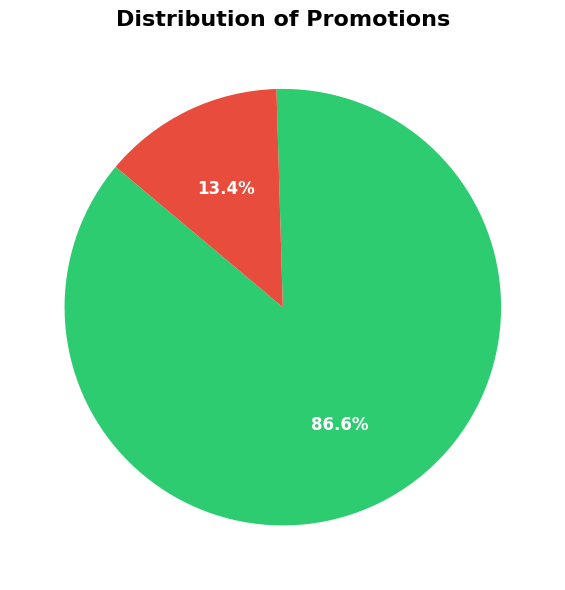

In [ ]:
onpromotion_counts = df['onpromotion'].value_counts(dropna=False)

# Custom labels
labels = ['Promoted' if val == True else 'Not Promoted' if val == False else 'Missing' for val in onpromotion_counts.index]

# Custom colors
colors = ['#2ecc71', '#e74c3c', '#95a5a6']  # green, red, gray

# Create the pie chart
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    onpromotion_counts,
    labels=labels,
    colors=colors[:len(onpromotion_counts)],
    autopct='%1.1f%%',
    startangle=140,
    textprops=dict(color="white")
)

# Styling
plt.setp(autotexts, size=12, weight="bold")
plt.setp(texts, size=12)
plt.title('Distribution of Promotions', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Downcast numeric columns to smallest possible types
for col in df.select_dtypes(include=['int', 'float']).columns:
    if pd.api.types.is_integer_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], downcast='integer')
    elif pd.api.types.is_float_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], downcast='float')

In [ ]:
del df['items_family']
del df['city']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59233 entries, 0 to 59232
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   unit_sales              59233 non-null  float32       
 1   store_nbr               59233 non-null  object        
 2   item_nbr                59233 non-null  object        
 3   onpromotion             59233 non-null  int8          
 4   dcoilwtico              59231 non-null  float32       
 5   holiday_type            59233 non-null  int8          
 6   locale                  12599 non-null  object        
 7   transferred             59233 non-null  int8          
 8   store_cluster           59233 non-null  int8          
 9   transactions            59233 non-null  int16         
 10  date                    59233 non-null  datetime64[ns]
 11  month                   59233 non-null  int8          
 12  month_day               59233 non-null  int8  

In [ ]:
df_enc = df.copy()

Use KNN to 5% find “weird” points — points far from their 10 nearest neighbors

In [ ]:
X_target = df_enc[['weighted_unit_sales']].values  # Needs 2D for KNN

# Step 2: Fit Nearest Neighbors
knn = NearestNeighbors(n_neighbors=10)
knn.fit(X_target)

# Step 3: Find average distance to neighbors
distances, _ = knn.kneighbors(X_target)
avg_distances = distances.mean(axis=1)

# Step 4: Define threshold to drop top 5% largest distances (biggest outliers)
threshold = np.percentile(avg_distances, 95)

# Step 5: Keep only points below the threshold
mask = avg_distances < threshold
df_enc = df_enc[mask].reset_index(drop=True)

print(f"✅ Outliers removed. New shape: {df_enc.shape}")

✅ Outliers removed. New shape: (56271, 25)


save my csv file in my Google Drive directory

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [ ]:
'''
file_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/df_train_2.csv'
df_a.to_csv(file_path, index=False) # Now you can use df_a
'''

"\nfile_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/df_train_2.csv'\ndf_a.to_csv(file_path, index=False) # Now you can use df_a\n"

In [ ]:
df_a = df_enc.copy()



---



In [ ]:
gc.collect() # gc.collect() are for garbage collection — basically cleaning up memory that Python no longer needs

22

# Analysis

## initial analysis

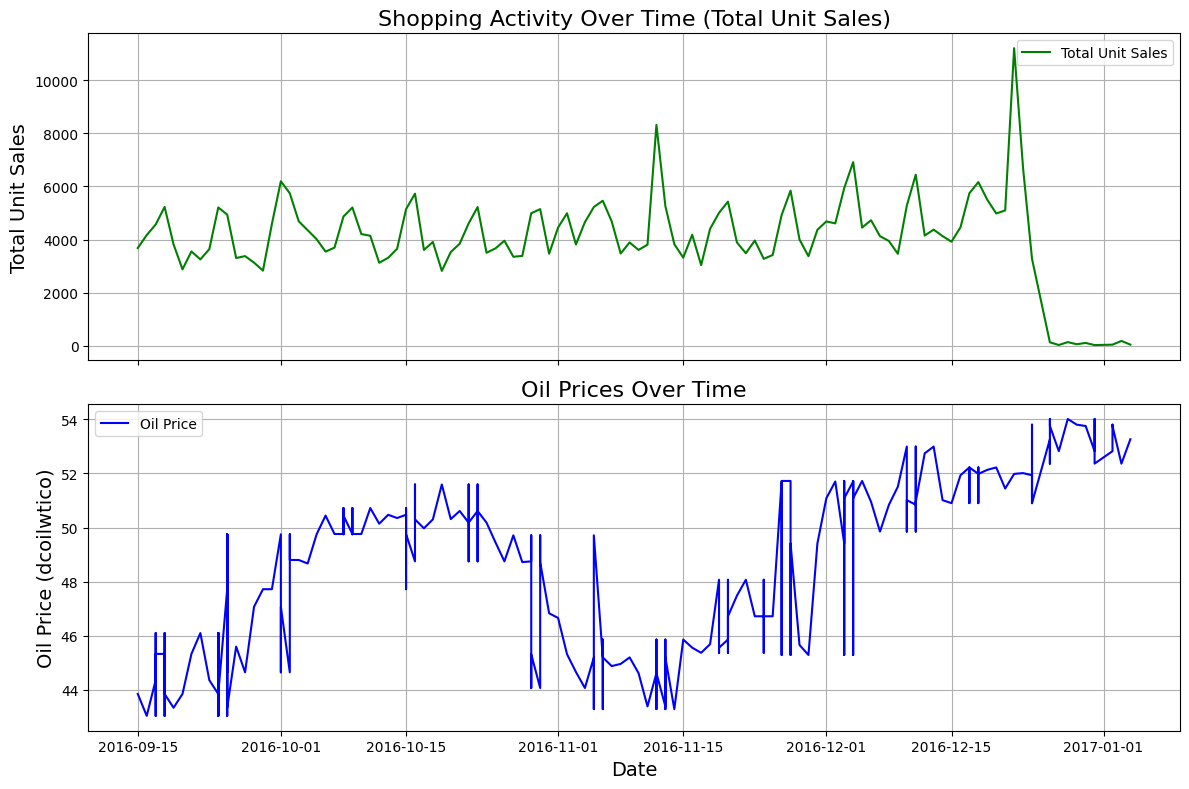

In [ ]:
# Ensure 'date' is datetime
df_enc['date'] = pd.to_datetime(df_enc['date'])

# Sort by date
df_enc = df_enc.sort_values('date')

# Group total unit_sales per day
sales_per_day = df_enc.groupby('date')['weighted_unit_sales'].sum()

# Create two vertically stacked plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top plot: Total unit sales over time
ax1.plot(sales_per_day.index, sales_per_day.values, color='green', label='Total Unit Sales')
ax1.set_title('Shopping Activity Over Time (Total Unit Sales)', fontsize=16)
ax1.set_ylabel('Total Unit Sales', fontsize=14)
ax1.legend()
ax1.grid(True)

# Bottom plot: Oil prices over time
ax2.plot(df_enc['date'], df_enc['dcoilwtico'], color='blue', label='Oil Price')
ax2.set_title('Oil Prices Over Time', fontsize=16)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Oil Price (dcoilwtico)', fontsize=14)
ax2.legend()
ax2.grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

✅ Mean Absolute Error: 6.2227
✅ R² Score: 0.1841


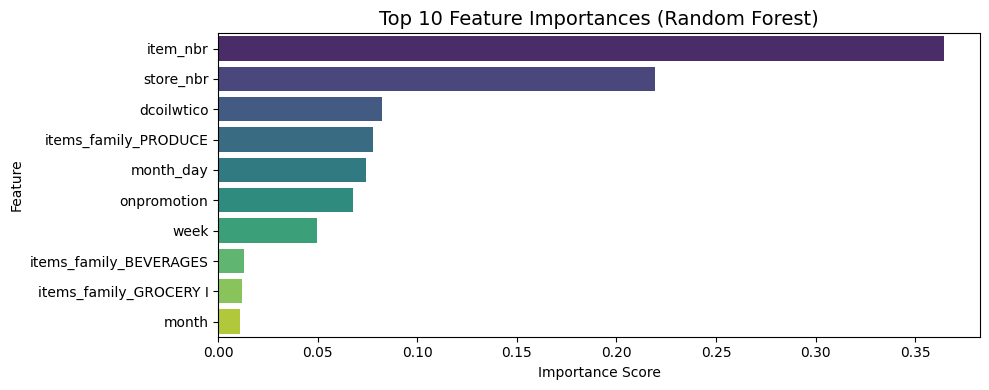

In [ ]:
# 1. Drop the original 'date' column and unnecessary columns:
X = df_enc.drop(columns=['date','unit_sales', "weighted_unit_sales",'transactions', 'locale'])  # Drop 'date','transactions', 'unit_sales', 'weighted_unit_sales', 'train_date' and 'locale' column
y = df_enc["weighted_unit_sales"]

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 3. Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
regressor.fit(X_train, y_train)

# 4. Predictions and Evaluation
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Mean Absolute Error: {mae:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# 5. Feature Importances
feature_importance = pd.Series(regressor.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(10)

# 6. Plotting
plt.figure(figsize=(10, 4))
sns.barplot(x=top_features, y=top_features.index, palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

As it's more comfortable here to analyse only 5 most popular product in 3 top shops in Guayas, I am going to limit my data.

In [ ]:
df_enc.shape

In [ ]:
# Step 1: Find the top 5 products by total unit_sales
top_5_items = (
    df_enc.groupby('item_nbr')['weighted_unit_sales']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Step 2: Filter df_enc to keep only those products
df_lin = df_enc[df_enc['item_nbr'].isin(top_5_items)].copy()

In [ ]:
df_lin = df_enc.copy()

In [ ]:
df_lin.shape

(56271, 25)

In [ ]:
# Step 1: Find the top 3 products by total unit_sales
top_3_shops = (
    df_lin.groupby('store_nbr')['weighted_unit_sales']
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

# Step 2: Filter df_enc to keep only those products
df_lin = df_lin[df_lin['store_nbr'].isin(top_3_shops)].copy()
df_lin.shape

(4388, 25)

In [ ]:
df_lin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4388 entries, 3665 to 56259
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   unit_sales              4388 non-null   float32       
 1   store_nbr               4388 non-null   object        
 2   item_nbr                4388 non-null   object        
 3   onpromotion             4388 non-null   int8          
 4   dcoilwtico              4388 non-null   float32       
 5   holiday_type            4388 non-null   int8          
 6   locale                  854 non-null    object        
 7   transferred             4388 non-null   int8          
 8   store_cluster           4388 non-null   int8          
 9   transactions            4388 non-null   int16         
 10  date                    4388 non-null   datetime64[ns]
 11  month                   4388 non-null   int8          
 12  month_day               4388 non-null   int8     

In [ ]:
# Check if the 'locale' column exists before attempting to delete it
if 'locale' in df_lin.columns:
    del df_lin['locale']
else:
    print("Column 'locale' not found in DataFrame.")

## deeper analysis

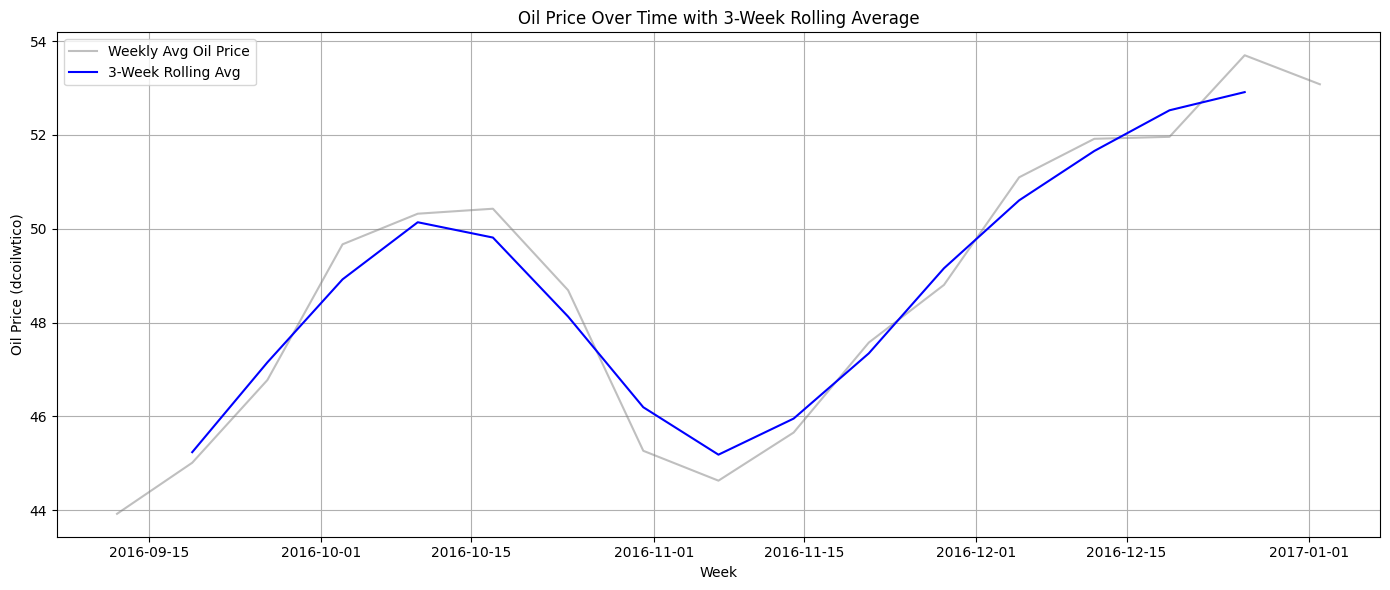

In [ ]:
# Ensure datetime format
df_lin['date'] = pd.to_datetime(df_lin['date'])

# Extract year and week number if not already present
df_lin['year'] = df_lin['date'].dt.isocalendar().year
df_lin['week'] = df_lin['date'].dt.isocalendar().week

# Group by week and compute average oil price per week
weekly_oil = df_lin.groupby(['year', 'week'])['dcoilwtico'].mean().reset_index()

# Combine year and week into a single datetime-like object for plotting
weekly_oil['year_week'] = pd.to_datetime(weekly_oil['year'].astype(str) + weekly_oil['week'].astype(str) + '1', format='%G%V%u')

# Apply 3-week rolling average
weekly_oil['rolling_avg'] = weekly_oil['dcoilwtico'].rolling(window=3, center=True).mean()

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_oil, x='year_week', y='dcoilwtico', label='Weekly Avg Oil Price', color='gray', alpha=0.5)
sns.lineplot(data=weekly_oil, x='year_week', y='rolling_avg', label='3-Week Rolling Avg', color='blue')
plt.title('Oil Price Over Time with 3-Week Rolling Average')
plt.xlabel('Week')
plt.ylabel('Oil Price (dcoilwtico)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

The result could be explained by fact that in a case oil price drops significantly customers switching to different products (most probably more necessary ones). Oil price fluctuations have some delayed influence on shopping activity.

more general overview which not include exact items 'item_nbr'

This exact graph proves my predictions that shopping activity in Ecuador is fully depends (and slightly delays - about three weeks) on volatile oil price, the product number was taken from the raw unfiltered data. For a better the market analysis I should include the items prices, as customers tend to move to cheaper products in times of uncertainty.

✅ Mean Absolute Error: 10.8806
✅ R² Score: -0.0172


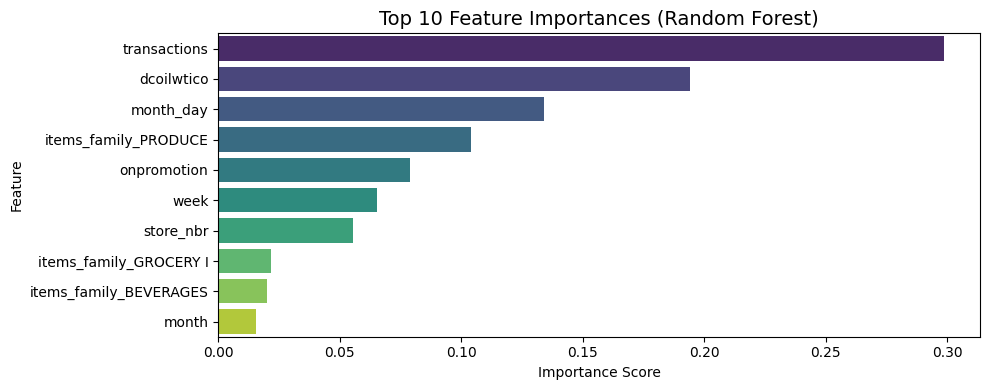

In [ ]:
# Assuming df_lin contains the data you want to use for the model
df_a = df_lin.copy()

# 1. Drop the original 'date' column and unnecessary columns:
# Removed 'year_week' from the list of columns to drop
X = df_a.drop(columns=['date','unit_sales', "weighted_unit_sales", 'item_nbr'])  # Drop 'date','unit_sales', 'weighted_unit_sales', also 'item_nbr' columns
y = df_a["weighted_unit_sales"]

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 3. Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
regressor.fit(X_train, y_train)

# 4. Predictions and Evaluation
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Mean Absolute Error: {mae:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# 5. Feature Importances
feature_importance = pd.Series(regressor.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(10)

# 6. Plotting
plt.figure(figsize=(10, 4))
sns.barplot(x=top_features, y=top_features.index, palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

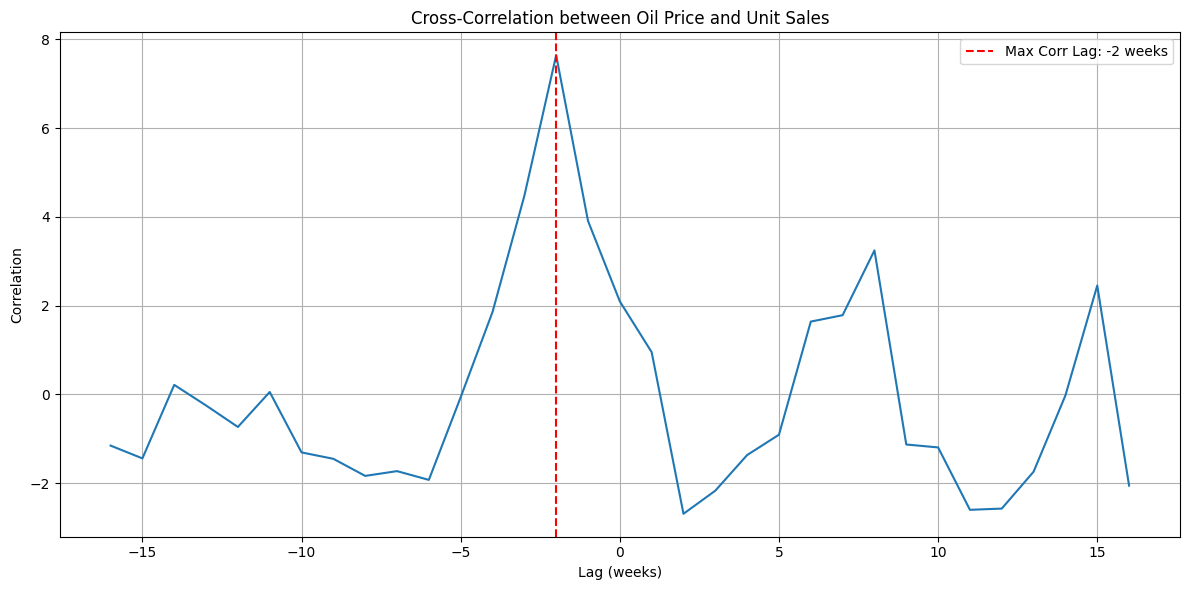

The peak correlation occurs at a lag of -2 weeks.


In [ ]:
# Extract year and week number
df_a['year'] = df_a['date'].dt.isocalendar().year
df_a['week'] = df_a['date'].dt.isocalendar().week

# Group by week
weekly_data = df_a.groupby(['year', 'week']).agg({
    'weighted_unit_sales': 'mean',
    'dcoilwtico': 'mean'
}).reset_index()

# Rename columns to match the expected names for dropna
weekly_data = weekly_data.rename(columns={
    'weighted_unit_sales': 'unit_sales_avg',
    'dcoilwtico': 'oil_price_avg'
})

# Create 'year_week' column before cleaning
weekly_data['year_week'] = pd.to_datetime(weekly_data['year'].astype(str) + weekly_data['week'].astype(str) + '1', format='%G%V%u')

# Remove NaNs
weekly_data_clean = weekly_data.dropna(subset=['unit_sales_avg', 'oil_price_avg'])

# Extract the two series
oil = weekly_data_clean['oil_price_avg'].values
sales = weekly_data_clean['unit_sales_avg'].values

# Detrend (optional but often useful)
oil = (oil - np.mean(oil)) / np.std(oil)
sales = (sales - np.mean(sales)) / np.std(sales)

# Compute cross-correlation
corr = correlate(sales, oil, mode='full')
lags = np.arange(-len(sales) + 1, len(oil))

# Find lag of max correlation
max_corr_index = np.argmax(corr)
lag_at_max_corr = lags[max_corr_index]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
plt.axvline(lag_at_max_corr, color='red', linestyle='--', label=f'Max Corr Lag: {lag_at_max_corr} weeks')
plt.title('Cross-Correlation between Oil Price and Unit Sales')
plt.xlabel('Lag (weeks)')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"The peak correlation occurs at a lag of {lag_at_max_corr} weeks.")

### Trend

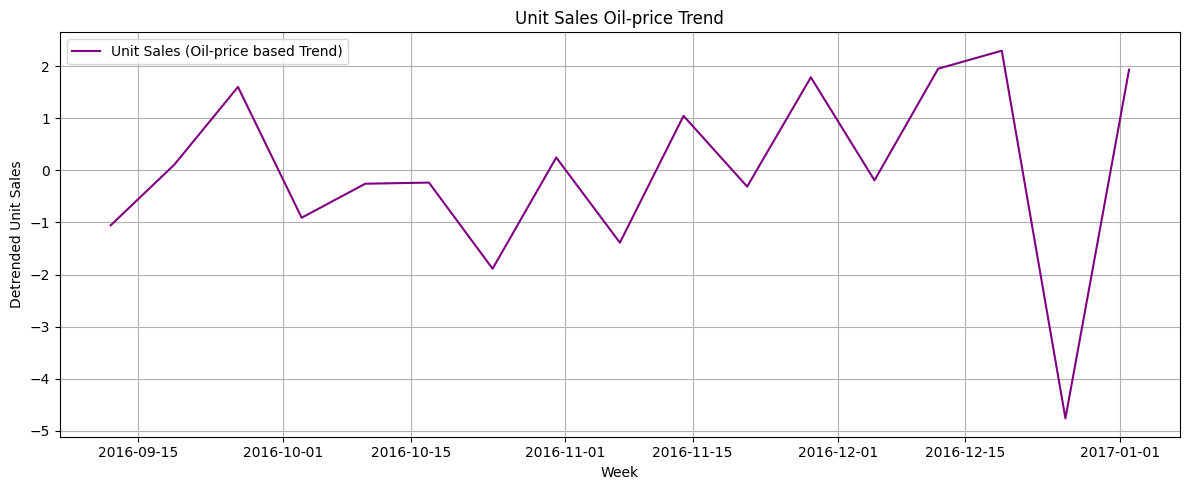

In [ ]:
# trend

# Clean data
weekly_data_clean = weekly_data.dropna(subset=['unit_sales_avg', 'oil_price_avg']).copy()

# Prepare variables
X = weekly_data_clean['oil_price_avg']
y = weekly_data_clean['unit_sales_avg']

# Add constant for intercept
X_const = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X_const).fit()

# Get residuals: the part of unit_sales not explained by oil price
# The line below was changed from '!=' to '='
weekly_data_clean['unit_sales_detrended'] = model.resid

# Optional: plot the detrended series
plt.figure(figsize=(12, 5))
plt.plot(weekly_data_clean['year_week'], weekly_data_clean['unit_sales_detrended'], label='Unit Sales (Oil-price based Trend)', color='purple')
plt.title('Unit Sales Oil-price Trend')
plt.xlabel('Week')
plt.ylabel('Detrended Unit Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Unit Sales with Oil Influence Removed

In [ ]:
df_a['date'] = pd.to_datetime(df_a['date'])

In [ ]:
# Extract year and week number
df_a['year'] = df_a['date'].dt.isocalendar().year
df_a['week'] = df_a['date'].dt.isocalendar().week

# Group by week
weekly_data = df_a.groupby(['year', 'week']).agg({
    'weighted_unit_sales': 'mean',
    'dcoilwtico': 'mean'
}).reset_index()

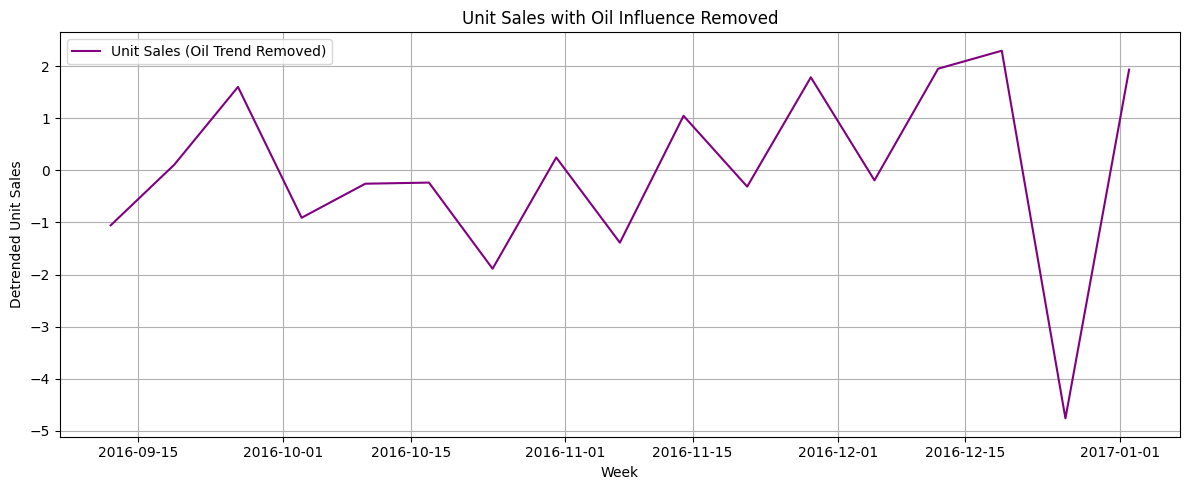

In [ ]:
# Extract year and week number
df_a['year'] = df_a['date'].dt.isocalendar().year
df_a['week'] = df_a['date'].dt.isocalendar().week

# Group by week
weekly_data = df_a.groupby(['year', 'week']).agg({
    'weighted_unit_sales': 'mean',
    'dcoilwtico': 'mean'
}).reset_index()

# Rename columns to match the expected names for dropna
weekly_data = weekly_data.rename(columns={
    'weighted_unit_sales': 'unit_sales_avg',
    'dcoilwtico': 'oil_price_avg'
})

# Create 'year_week' column before cleaning
weekly_data['year_week'] = pd.to_datetime(weekly_data['year'].astype(str) + weekly_data['week'].astype(str) + '1', format='%G%V%u')


# Clean data
weekly_data_clean = weekly_data.dropna(subset=['unit_sales_avg', 'oil_price_avg']).copy()

# Prepare variables
X = weekly_data_clean['oil_price_avg']
y = weekly_data_clean['unit_sales_avg']

# Add constant for intercept
X_const = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X_const).fit()

# Get residuals: the part of unit_sales not explained by oil price
weekly_data_clean['unit_sales_detrended'] = model.resid

# Optional: plot the detrended series
plt.figure(figsize=(12, 5))
plt.plot(weekly_data_clean['year_week'], weekly_data_clean['unit_sales_detrended'], label='Unit Sales (Oil Trend Removed)', color='purple')  # Assuming 'year_week' column exists
plt.title('Unit Sales with Oil Influence Removed')
plt.xlabel('Week')
plt.ylabel('Detrended Unit Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## apply mathematical series analysis for the stable period from 15 September 2016 till 15 December 2016

In [ ]:
df_ts = df_enc[(df_enc['date'] <= '2016-12-15') & (df_enc['date'] >= '2016-09-15')].copy()

In [ ]:
if 'locale' in df_ts.columns:
    del df_ts['locale']
else:
    print("Column 'locale' not found in DataFrame.")

In [ ]:
df_ts.sample(5)

,unit_sales,store_nbr,item_nbr,onpromotion,dcoilwtico,holiday_type,transferred,store_cluster,transactions,date,...,items_family_BEVERAGES,items_family_GROCERY I,items_family_PRODUCE,items_family_nan,year_scaled,city_Daule,city_Guayaquil,city_Libertad,city_Playas,city_nan
910,7.0,34,1246785,0,45.330002,0,0,3,2126,2016-09-24,...,0,1,0,0,-1,0,1,0,0,0
991,2.0,12,1342003,0,45.330002,0,0,0,1160,2016-09-21,...,0,1,0,0,-1,0,0,0,0,1
19757,5.0,49,1463632,0,51.590000,0,0,0,2579,2016-10-19,...,1,0,0,0,-1,0,0,0,0,1
13293,6.0,45,2010233,0,49.759998,0,0,0,3150,2016-10-10,...,0,1,0,0,-1,0,0,0,0,1
13023,3.0,16,268834,0,50.439999,0,0,0,727,2016-10-08,...,0,1,0,0,-1,0,0,0,0,1


### Time series decomposition

weighted_unit_sales

In [ ]:
# create a series with datetime index
ts_favorita = pd.Series(index=pd.to_datetime(df_ts['week']),
                                  data = df_ts['weighted_unit_sales'].values)

In [ ]:
result = seasonal_decompose(ts_favorita, model='additive', period=52)

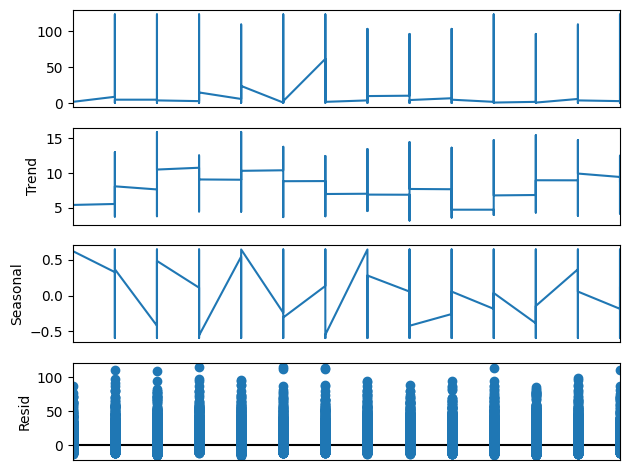

In [ ]:
result.plot()
plt.show()

same season decomposition based on 3-week rolling window

In [ ]:
# Ensure 'week' is datetime
df_ts['week'] = pd.to_datetime(df_ts['week'])

# Set 'week' as index
df_ts = df_ts.set_index('week')

# Apply 3-week (21 days) rolling window to 'weighted_unit_sales'
df_ts['rolling_3week_sales'] = df_ts['weighted_unit_sales'].rolling('21D').mean()

# Optional: reset index if you want to work with 'week' as a column again
df_ts = df_ts.reset_index()

In [ ]:
ts_3w = pd.Series(index=pd.to_datetime(df_ts['week']),
                                  data = df_ts['rolling_3week_sales'].values)

In [ ]:
result_3w = seasonal_decompose(ts_3w, model='additive', period=52)

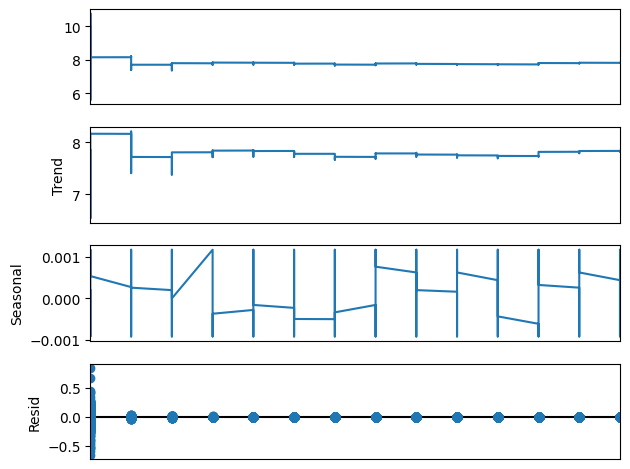

In [ ]:
result_3w.plot()
plt.show()

transactions

In [ ]:
df_ts = df_ts.reset_index()

In [ ]:
ts_favorita = pd.Series(index=pd.to_datetime(df_ts['week']),
                                  data = df_ts['transactions'].values)

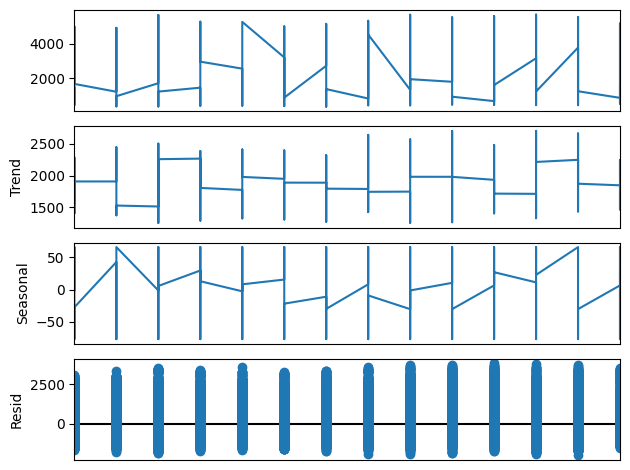

In [ ]:
result = seasonal_decompose(ts_favorita, model='additive', period=52)
result.plot()
plt.show()

### ARIMA

In [ ]:
def model_evaluation(model, test_size = 52, exog=None):
    '''
    This function evaluates the model on a given test size
    '''
    train_predictions = model.predict()
    if exog is not None:
        forecast = model.get_forecast(test_size, exog = df_ts[-test_size:][exog])
        test_predictions = forecast.predicted_mean
    else:
        try:
            test_predictions = model.forecast(test_size)
        except:
            test_predictions = model.predict(test_size)
    print(len(test_predictions))
    mae = mean_absolute_error(df[-test_size:]['weighted_unit_sales'], test_predictions)
    r2 = r2_score(df[-test_size:]['weighted_unit_sales'], test_predictions)
    print(f'R2 score {np.round(r2,2)}\nMean absolute error {np.round(mae,2)}')
    fig, ax = plt.subplots()
    ax.plot(train_predictions, label = 'Train predictions')
    ax.plot(df['weighted_unit_sales'], label = 'Input data')
    ax.plot(test_predictions, label = 'Test predictions')
    plt.legend()
    plt.show()

    # add return test predictoins

In [ ]:
train, test = df[:-52], df[-52:]

In [ ]:
!pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA # Import the ARIMA class

In [ ]:
'''
model = ARIMA(endog=train,
              order = (1,1,15))
model_fit = model.fit()
print(model_fit.summary())
'''

'\nmodel = ARIMA(endog=train,\n              order = (1,1,15))\nmodel_fit = model.fit()\nprint(model_fit.summary())\n'

✅ Mean Absolute Error: 10.8806
✅ R² Score: -0.0172


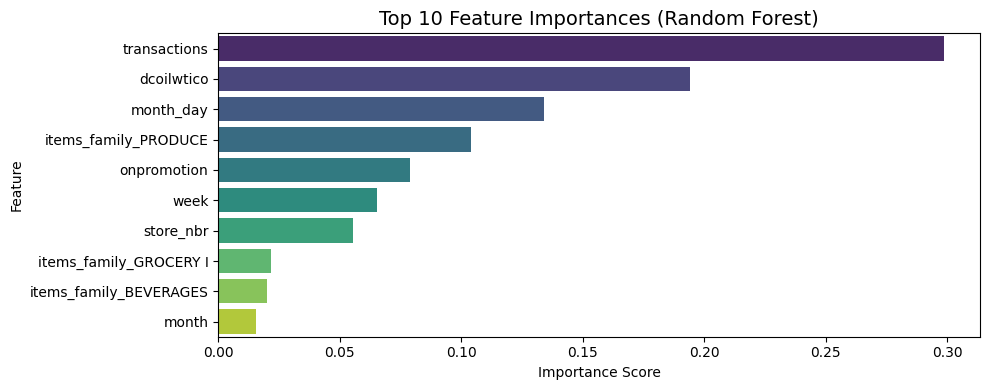

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                50467
Model:                ARIMA(1, 1, 15)   Log Likelihood             -192197.639
Date:                Sun, 04 May 2025   AIC                         384429.279
Time:                        09:01:41   BIC                         384579.373
Sample:                             0   HQIC                        384476.275
                              - 50467                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8996      0.075    -11.936      0.000      -1.047      -0.752
ma.L1         -0.0902      0.076     -1.194      0.232      -0.238       0.058
ma.L2         -0.8968      0.075    -11.991      0.0

In [ ]:
# Assuming df_lin contains the data you want to use for the model
df_a = df_lin.copy()

# 1. Drop the original 'date' column and unnecessary columns:
# Removed 'year_week' from the list of columns to drop
X = df_a.drop(columns=['date','unit_sales', "weighted_unit_sales", 'item_nbr'])  # Drop 'date','unit_sales', 'weighted_unit_sales', also 'item_nbr' columns
y = df_a["weighted_unit_sales"]

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 3. Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
regressor.fit(X_train, y_train)

# 4. Predictions and Evaluation
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Mean Absolute Error: {mae:.4f}")
print(f"✅ R² Score: {r2:.4f}")

# 5. Feature Importances
feature_importance = pd.Series(regressor.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(10)

# 6. Plotting
plt.figure(figsize=(10, 4))
sns.barplot(x=top_features, y=top_features.index, palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



# Ensure 'week' column is in datetime format if it's not already
df_ts['week'] = pd.to_datetime(df_ts['week'])

# Set 'week' as index
df_ts = df_ts.set_index('week')

# create a series with datetime index for ARIMA
ts_favorita = pd.Series(data=df_ts['weighted_unit_sales'].values, index=df_ts.index)

# Split the time series data into train and test sets
train_ts, test_ts = ts_favorita[:-52], ts_favorita[-52:]

# Apply ARIMA model
model = ARIMA(endog=train_ts, order=(1, 1, 15))  # Using the time series data
model_fit = model.fit()
print(model_fit.summary())

52
R2 score -0.07
Mean absolute error 9.33


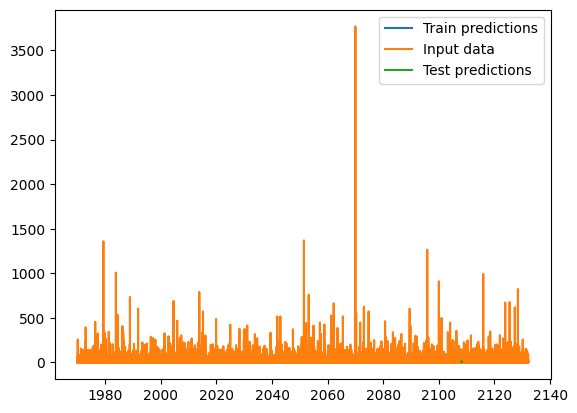

In [ ]:
model_evaluation(model_fit)

### ExponentialSmoothing

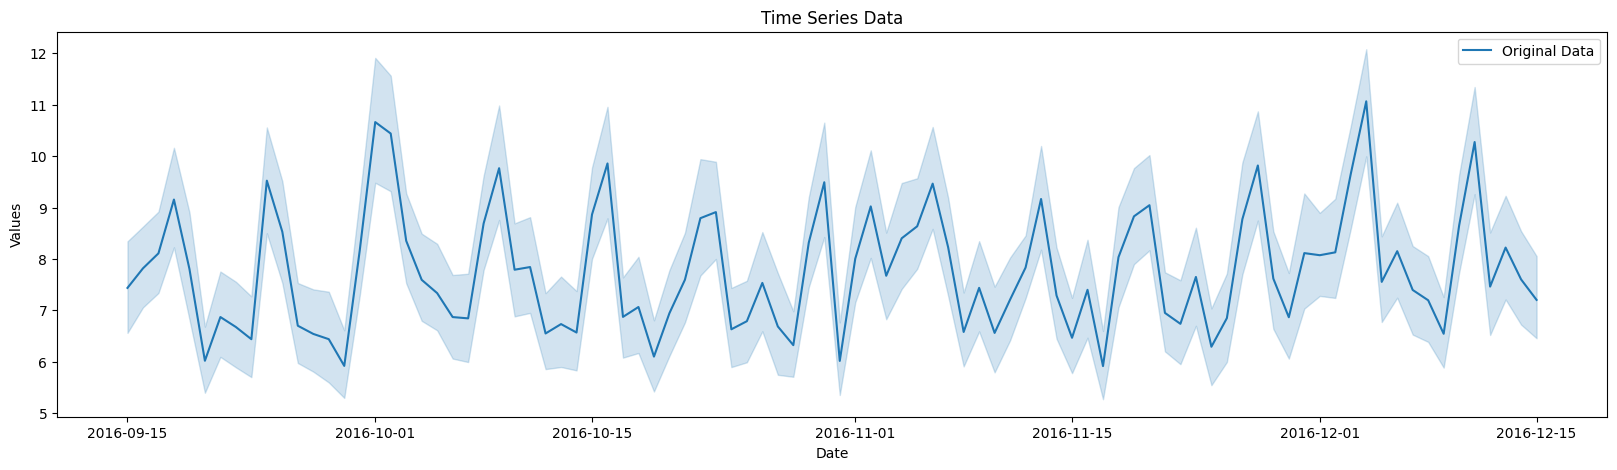

In [ ]:
plt.figure(figsize=(20, 5)) # Plotting Code (Just Visualizing)
sns.lineplot(x='date', y='weighted_unit_sales', data=df_ts, label='Original Data')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series Data')
plt.legend()
plt.show()

In [ ]:
'''
train_numeric = train[['weighted_unit_sales']]

mod_holt = Holt(train_numeric['weighted_unit_sales']).fit()

preds = mod_holt.forecast(len(test))
'''

"\ntrain_numeric = train[['weighted_unit_sales']]\n\nmod_holt = Holt(train_numeric['weighted_unit_sales']).fit()\n\npreds = mod_holt.forecast(len(test))\n"

In [ ]:
split_date = '01-Nov-2016' # Train/Test Split
df_ts_train = df_ts.loc[df_ts['date'] <= split_date].copy()
df_ts_test = df_ts.loc[df_ts['date'] > split_date].copy()

In [ ]:
train_numeric = df_ts_train[['weighted_unit_sales']] # Extracting Just the Numeric Data for Model

In [ ]:
mod_holt = Holt(train_numeric['weighted_unit_sales']).fit() # Fit Holt’s Linear Model (Exponential Smoothing)

In [ ]:
preds = mod_holt.forecast(len(df_ts_test)) # Make Forecast

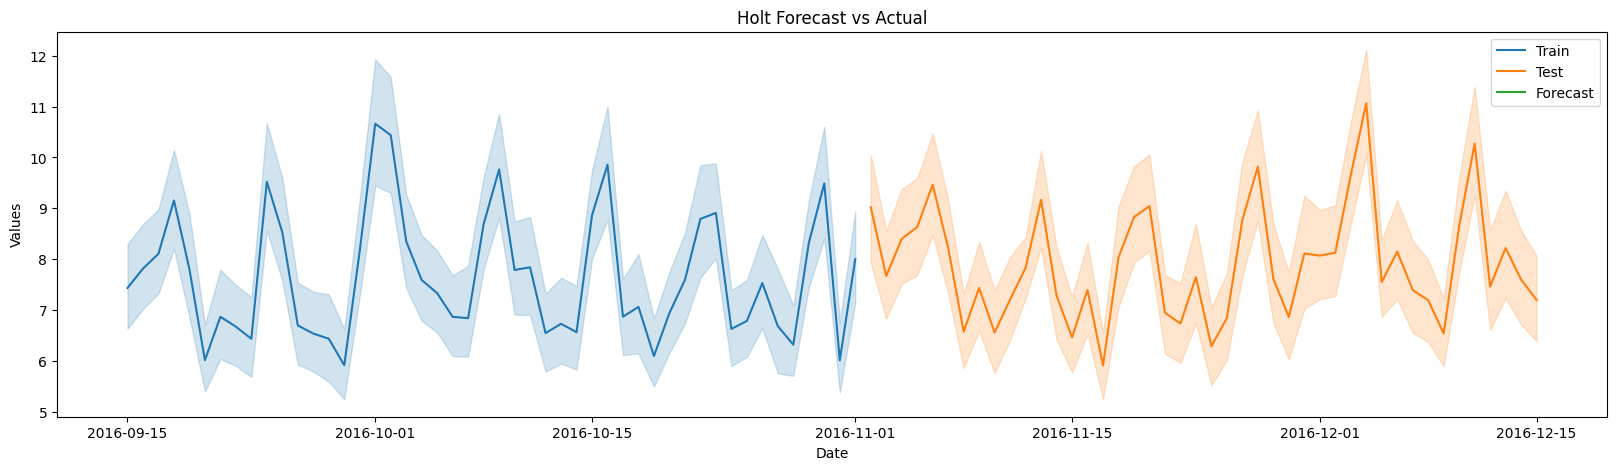

In [ ]:
'''
plt.figure(figsize=(20, 5)) # Plot the Forecast vs. Actual
sns.lineplot(x=df_ts_train['date'], y=df_ts_train['weighted_unit_sales'], label='Train')
sns.lineplot(x=df_ts_test['date'], y=df_ts_test['weighted_unit_sales'], label='Test')
# Reset index of df_ts_test before plotting to avoid duplicate index issues
sns.lineplot(x=df_ts_test.reset_index()['date'], y=preds, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Holt Forecast vs Actual')
plt.legend()
plt.show()
'''

**Why is your forecast over-optimistic?**

When using Holt’s Linear Trend, the model assumes the current trend continues into the future. If the recent data shows an upward spike, Holt will think that growth will go on forever, which causes:

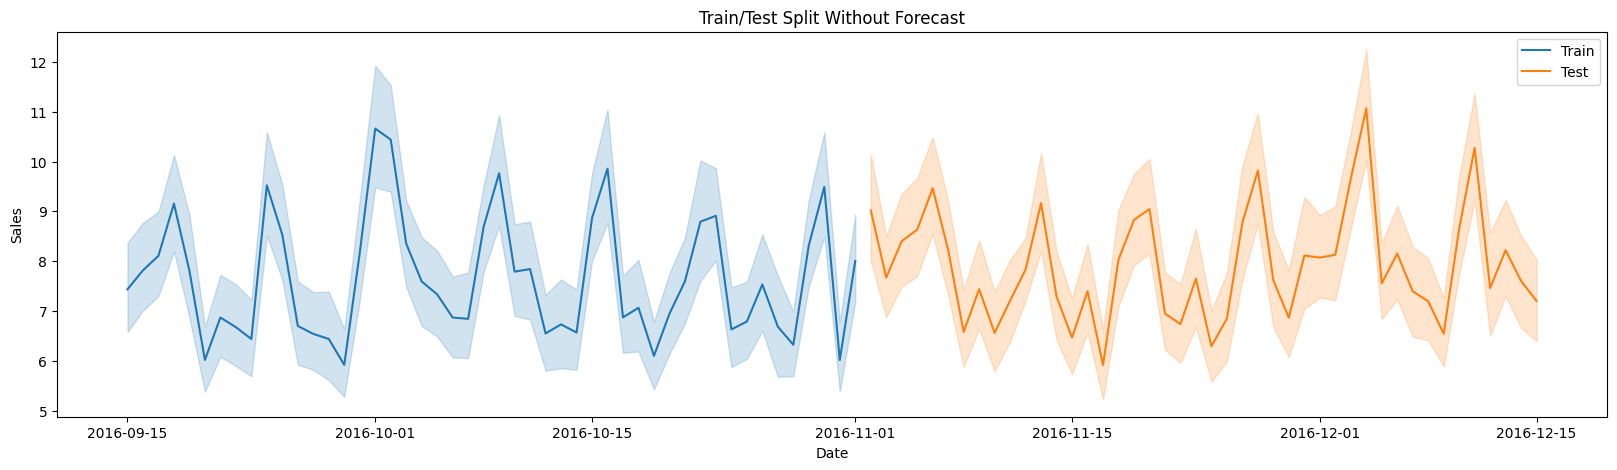

In [ ]:
plt.figure(figsize=(20, 5)) # Graph Without Forecast (Just Train/Test Actual Data)
sns.lineplot(x=df_ts_train['date'], y=df_ts_train['weighted_unit_sales'], label='Train')
sns.lineplot(x=df_ts_test['date'], y=df_ts_test['weighted_unit_sales'], label='Test')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Train/Test Split Without Forecast')
plt.legend()
plt.show()

In my assessment, the generally poor predictive performance observed when applying standard forecasting techniques to the Kaggle ‘Favorita’ dataset arises primarily from the lack of segmentation in the data. For forecasts to achieve greater accuracy and reliability, an essential preliminary step should involve clustering the data. Ecuador, as a nation, is characterised by profound socio-economic divisions; consequently, supermarkets situated even within the same city may exhibit markedly divergent consumer behaviours and sales patterns. If these heterogeneities are captured through clustering and analysed separately, the resultant predictive models are likely to be significantly more robust.

However, even under optimal segmentation, it must be acknowledged that any forecasts of Ecuadorian consumer activity remain highly constrained temporally. In particular, the predictive horizon should likely be limited to no more than several weeks. This is due to the pronounced dependency of national consumption on the global price of oil—Ecuador’s principal economic driver. Fluctuations in oil prices can exert an influence on retail activity of up to 500%, particularly on a weekly basis, whereas cultural and public holidays may contribute variances of up to 50%.

To attempt forecasting Ecuador’s retail dynamics without first clustering population regions is, in my view, methodologically unsound. It is akin to aggregating consumer behaviour data from three demographically and culturally distinct Israeli towns—such as Bnei Brak, Umm al-Fahm, and Nof HaGalil—and attempting to draw unified conclusions. Each, if modelled independently, may yield highly reliable predictions, but when lumped together, the result is statistical chaos.

Similarly, the approach often suggested in academic settings—where Ecuadorian provinces are merely treated as separate entities (e.g., Haifa versus the Negev, in the Israeli context)—provides insufficient resolution. It is a superficial division that overlooks the crucial intra-provincial disparities. As such, it contributes little to the quality of forecasting.

### K-Nearest Neighbors (KNN)

Create Lag Features

In [ ]:
# I will create lags on full dataset, then split again
df_lag = df_ts[['date', 'weighted_unit_sales']].copy()

# Create lag features (1-day and 2-day lags)
df_lag['lag_1'] = df_lag['weighted_unit_sales'].shift(1)
df_lag['lag_2'] = df_lag['weighted_unit_sales'].shift(2)
df_lag['lag_3'] = df_lag['weighted_unit_sales'].shift(3)

Drop NaNs from Lags

In [ ]:
# Drop rows where lag values are NaN (only affects the first 2 rows)
df_lag.dropna(inplace=True)

Split Train/Test Again (after lags)

In [ ]:
'''
Why do split train/test again after creating lag features?

Because creating lag features changes the dataset: it adds new columns,
and it introduces missing values at the top (from shifting), which changes the row indices

originally had this:
df_ts_train = df_ts[df_ts['date'] <= split_date]

But later do this:
df_lag = df_ts[['date', 'weighted_unit_sales']]
df_lag['lag_1'] = df_lag['weighted_unit_sales'].shift(1)
df_lag['lag_2'] = df_lag['weighted_unit_sales'].shift(2)
df_lag.dropna(inplace=True)
'''

"\nWhy do split train/test again after creating lag features?\n\nBecause creating lag features changes the dataset: it adds new columns,\nand it introduces missing values at the top (from shifting), which changes the row indices\n\noriginally had this:\ndf_ts_train = df_ts[df_ts['date'] <= split_date]\n\nBut later do this:\ndf_lag = df_ts[['date', 'weighted_unit_sales']]\ndf_lag['lag_1'] = df_lag['weighted_unit_sales'].shift(1)\ndf_lag['lag_2'] = df_lag['weighted_unit_sales'].shift(2)\ndf_lag.dropna(inplace=True)\n"

In [ ]:
split_date = '01-Nov-2016'

In [ ]:
df_train = df_lag[df_lag['date'] <= split_date].copy() # Now apply the split again on df_lag
df_test = df_lag[df_lag['date'] > split_date].copy()

Define Features and Target

In [ ]:
# Features are the lag values
X_train = df_train[['lag_1', 'lag_2', 'lag_3']]
y_train = df_train['weighted_unit_sales']

# For now, we predict one step ahead
X_test = df_test[['lag_1', 'lag_2', 'lag_3']]
y_test = df_test['weighted_unit_sales']

Train KNN Model

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=2)  # can try 3, 5...
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

Predict the Test Set

In [ ]:
# Predict for all test rows at once
y_pred = model.predict(X_test)

Plot Actual vs Predicted

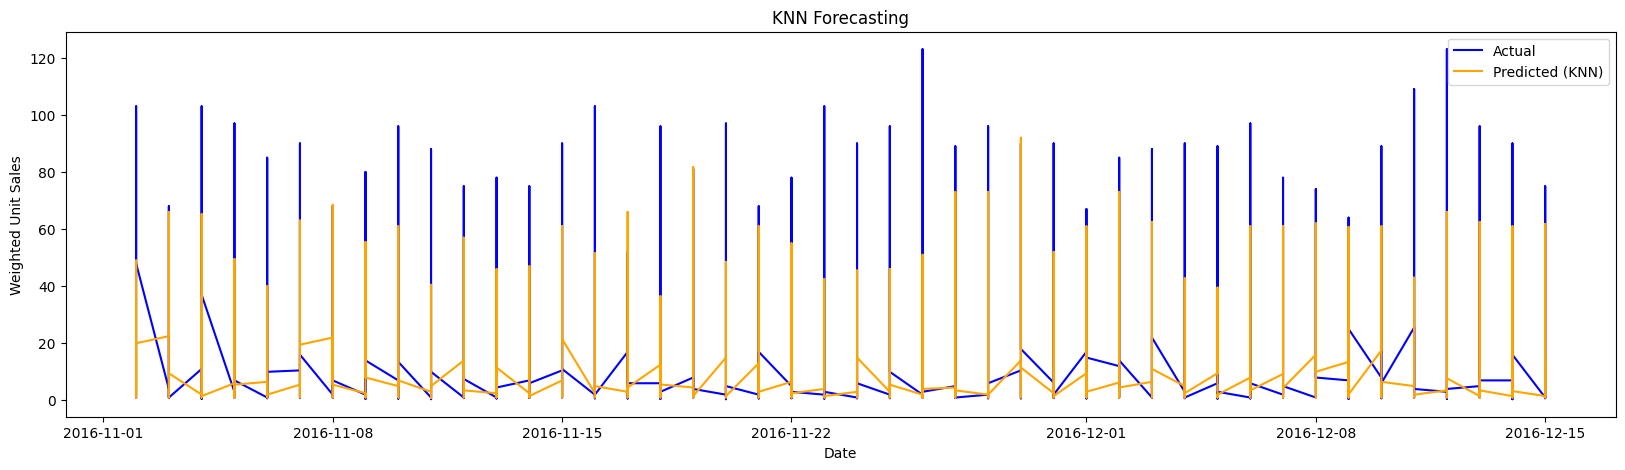

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df_test['date'], y_test, label='Actual', color='blue')
plt.plot(df_test['date'], y_pred, label='Predicted (KNN)', color='orange')
plt.xlabel('Date')
plt.ylabel('Weighted Unit Sales')
plt.title('KNN Forecasting')
plt.legend()
plt.show()

***Common Reasons Why KNN Predictions Are Too Low***

**Lags are not predictive enough**

If the lag_1, lag_2 values are small compared to actual future values (e.g., due to trends or holidays), then the model is averaging small numbers and can’t follow the real pattern.

Fix:
	•	Add more lags (e.g. lag_3, lag_7)
	•	Add rolling averages (e.g. last 3 or 7 days)
	•	Add date-based features (e.g., day of week, holiday)


**No scaling or normalization**

KNN is sensitive to feature scale. If the sales are large (e.g. 1000s), and the lags vary a lot, the distance between points gets distorted

### XGBoost model

 Step 1: I’ve already done previously in KNN model

You created:

	•	Lag features: lag_1, lag_2, lag_3
	•	Split into train and test
	•	Prepared X_train, y_train, X_test, y_test

Step 2: Add Rolling Features *(Optional but Helpful)*

In [ ]:
df_lag['rolling_mean_7'] = df_lag['weighted_unit_sales'].rolling(window=7).mean() # Add Rolling Features to Full Dataset
df_lag['rolling_std_7'] = df_lag['weighted_unit_sales'].rolling(window=7).std()

In [ ]:
df_lag.dropna(inplace=True) # Then again, drop rows with NaN (rolling mean needs 7 days)

In [ ]:
gc.collect() # gc.collect() are for garbage collection — basically cleaning up memory that Python no longer needs

8081

Now the df_lag has:

	•	lag_1, lag_2, lag_3
	•	rolling_mean_7, rolling_std_7
	•	weighted_unit_sales (target)

Step 3: Split Again (Final Time)

In [ ]:
df_train = df_lag[df_lag['date'] <= split_date].copy()
df_test = df_lag[df_lag['date'] > split_date].copy()

Step 4: Define Features and Target

In [ ]:
feature_cols = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_7', 'rolling_std_7']

X_train = df_train[feature_cols]
y_train = df_train['weighted_unit_sales']

X_test = df_test[feature_cols]
y_test = df_test['weighted_unit_sales']

Step 5: Fit XGBoost

In [ ]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Step 6: Make Predictions

In [ ]:
y_pred = model.predict(X_test)

Step 7: Plot Results

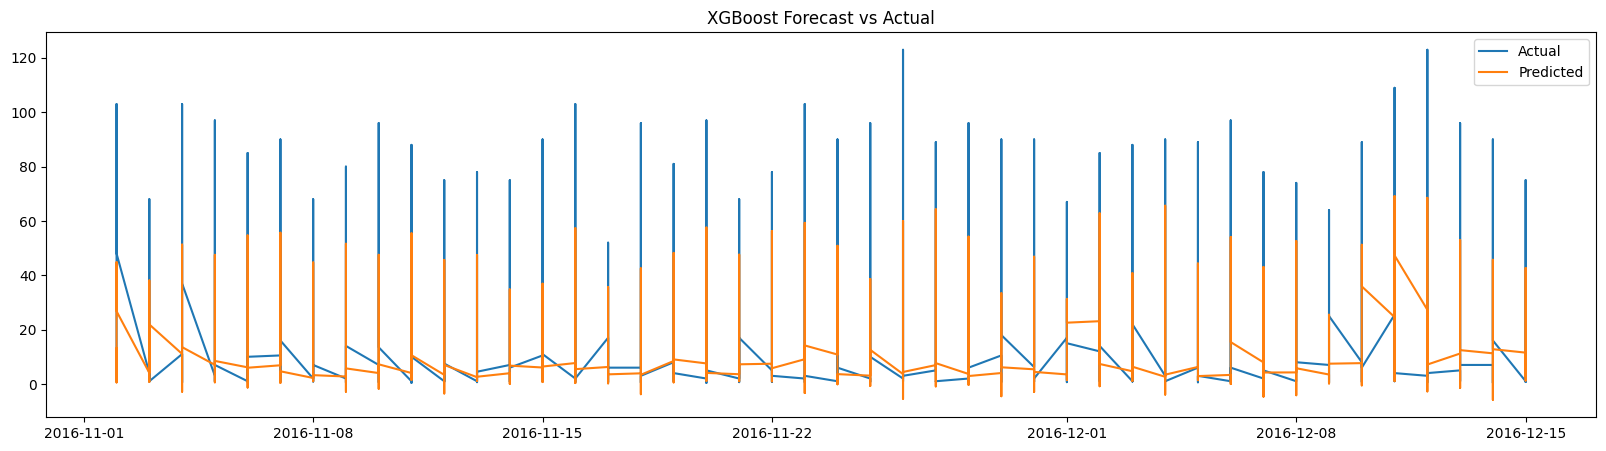

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_test['date'], y_test, label='Actual')
plt.plot(df_test['date'], y_pred, label='Predicted')
plt.legend()
plt.title('XGBoost Forecast vs Actual')
plt.show()

In [ ]:
# Predictions already made: y_pred
# True values: y_test

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

R² Score: 0.202
RMSE: 9.935
MAE: 6.079
